# Comparing Upper Envelope Algorithms: DC-EGM by HARK vs FUES by Akshay vs FUES by Bonn

This notebook compares the three algorithms in a case where the policy function is monotone (writing a will) as well when the policy function is not monotone (durables and non-durables).

For references:
- [HARK](https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb)
- [FUES-Original](https://github.com/akshayshanker/FUES_EGM)
- [FUES-Bonn](https://github.com/segsell/dc-egm) 

# DC-EGM by Iskhakov, F. , Jørgensen, T. H., Rust, J. and Schjerning, B. (2017)

Algorithm:
1. Compute $c$, $v$, $m$ using EGM
2. Find non-decreasing segments in value function
3. Find cross-points
4. Keep maximum value points only
5. Keep corresponding $c$ and $m$

# Fast Upper Envelope Scan (FUES) by Dobrescu, L., & Shanker, A. (2022)

Algorithm:
1. Compute $c$, $m$, $v$ using EGM
2. Set a pre-determined ‘jump detection’ threshold  ̄$M$
3. Sort all sequences in order of the endogenous grid $m$.
4. Start from 2nd grid point ($i = 2$), compute
$$
g_i = \frac{v_i - v_{i-1}}{m_i - m_{i-1}}\\
g_{i+1} = \frac{v_{i+1} - v_{i}}{m_{i+1} - m_i}\\
h_i = \frac{c_{i+1} - c_{i}}{m_{i+1} - m_i}
$$
5. If $M > h_i$ (jump) and $g_{i+1} < g_i$ (right turn), remove point $i+1$ from c-, m-, v-grid. Otherwise, set $i = i+1$
6. If i+1 < len(m), repeat from 5 

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import time
# here for now, should be
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp
from HARK.dcegm import calc_nondecreasing_segments, upper_envelope, calc_cross_points
from HARK.econforgeinterp import LinearFast

from HARK.utilities import CRRAutilityP_inv, CRRAutility, CRRAutilityP
from HARK.ConsumptionSaving.ConsIndShockModel import utility, utility_inv, utilityP_inv

# FUES
from FUES import FUES
# FUES Bonner
from fast_upper_envelope import fast_upper_envelope

## Example 1: Writing a Will (see [original](https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb))

In [2]:
# Import tools for linear interpolation and finding optimal
# discrete choices.

# Import CRRA utility (and related) functions from HARK

# Solution method parameters
aGrid = np.linspace(0, 8, 400)  # Savings grid for EGM.

# Model parameters

# Parameters that need to be fixed
# Relative risk aversion. This is fixed at 2 in order to mantain
# the analytical solution that we use, from Carroll (2000)
CRRA = 2

# Parameters that can be changed.
w = 1  # Deterministic wage per period.
# Fraction of resources charged by lawyer for writing a will.
willCstFac = 0.35
DiscFac = 0.98  # Time-discount factor.

# Define utility (and related) functions


def u(x):
    return CRRAutility(x, CRRA)


def uP(x):
    return CRRAutilityP(x, CRRA)


def uPinv(x):
    return CRRAutilityP_inv(x, CRRA)


# Create a grid for market resources
mGrid = (aGrid - aGrid[0]) * 1.5
mGridPlots = np.linspace(w, 10 * w, 100)
mGridPlotsC = np.insert(mGridPlots, 0, 0)

# Transformations for value funtion interpolation


def vTransf(x):
    return np.exp(x)


def vUntransf(x):
    return np.log(x)

### Period 3

C:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\utilities.py:142: RuntimeWarning: divide by zero encountered in reciprocal
  return c ** (1.0 - gam) / (1.0 - gam)


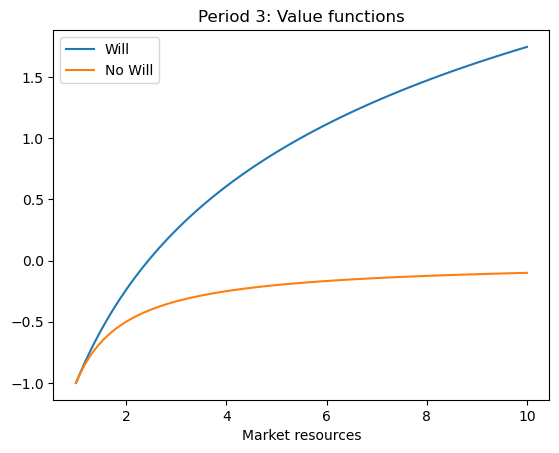

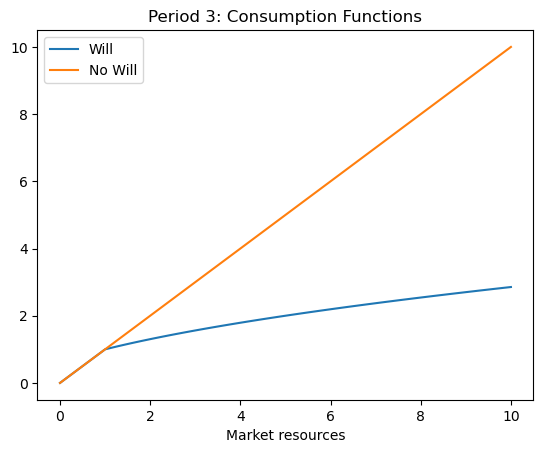

In [3]:
# Agent without a will
mGrid3_no = mGrid
cGrid3_no = mGrid
vGrid3_no = u(cGrid3_no)

# Create functions
c3_no = LinearInterp(mGrid3_no, cGrid3_no)  # (0,0) is already here.
vT3_no = LinearInterp(mGrid3_no, vTransf(vGrid3_no), lower_extrap=True)


def v3_no(x):
    return vUntransf(vT3_no(x))


# Agent with a will

# Define an auxiliary function with the analytical consumption expression


def c3will(m):
    return np.minimum(m, -0.5 + 0.5 * np.sqrt(1 + 4 * (m + 1)))


# Find the kink point
mKink = 1.0
indBelw = mGrid < mKink
indAbve = mGrid > mKink

mGrid3_wi = np.concatenate([mGrid[indBelw], np.array([mKink]), mGrid[indAbve]])

cGrid3_wi = c3will(mGrid3_wi)

cAbve = c3will(mGrid[indAbve])
beqAbve = mGrid[indAbve] - c3will(mGrid[indAbve])
vGrid3_wi = np.concatenate(
    [u(mGrid[indBelw]), u(np.array([mKink])), u(cAbve) + np.log(1 + beqAbve)]
)

# Create functions
c3_wi = LinearInterp(mGrid3_wi, cGrid3_wi)  # (0,0) is already here
vT3_wi = LinearInterp(mGrid3_wi, vTransf(vGrid3_wi), lower_extrap=True)


def v3_wi(x):
    return vUntransf(vT3_wi(x))


plt.figure()

plt.plot(mGridPlots, v3_wi(mGridPlots), label="Will")
plt.plot(mGridPlots, v3_no(mGridPlots), label="No Will")
plt.title("Period 3: Value functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

plt.plot(mGridPlotsC, c3_wi(mGridPlotsC), label="Will")
plt.plot(mGridPlotsC, c3_no(mGridPlotsC), label="No Will")
plt.title("Period 3: Consumption Functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

### Period 2

In [4]:
# Second period, not writing a will

# Compute market resources at 3 with and without a will
mGrid3_cond_nowi = aGrid + w
# Compute marginal value of assets in period 3 for each ammount of savings in 2
vPGrid3_no = uP(c3_no(mGrid3_cond_nowi))
# Get consumption through EGM inversion of the euler equation
cGrid2_cond_no = uPinv(DiscFac * vPGrid3_no)

# Get beginning-of-period market resources
mGrid2_cond_no = aGrid + cGrid2_cond_no

# Compute value function
vGrid2_cond_no = u(cGrid2_cond_no) + DiscFac * v3_no(mGrid3_cond_nowi)

# Create interpolating value and consumption functions
vT2_cond_no = LinearInterp(mGrid2_cond_no, vTransf(vGrid2_cond_no), lower_extrap=True)


def v2_cond_no(x):
    return vUntransf(vT2_cond_no(x))


c2_cond_no = LinearInterp(
    np.insert(mGrid2_cond_no, 0, 0), np.insert(cGrid2_cond_no, 0, 0)
)

In [5]:
# Second period, writing a will

# Compute market resources at 3 with and without a will
mGrid3_cond_will = (1 - willCstFac) * (aGrid + w)
# Compute marginal value of assets in period 3 for each ammount of savings in 2
vPGrid3_wi = uP(c3_wi(mGrid3_cond_will))
# Get consumption through EGM inversion of the euler equation
cGrid2_cond_wi = uPinv(DiscFac * (1 - willCstFac) * vPGrid3_wi)
# Get beginning-of-period market resources
mGrid2_cond_wi = aGrid + cGrid2_cond_wi

# Compute value function
vGrid2_cond_wi = u(cGrid2_cond_wi) + DiscFac * v3_wi(mGrid3_cond_will)

# Create interpolating value and consumption functions
vT2_cond_wi = LinearInterp(mGrid2_cond_wi, vTransf(vGrid2_cond_wi), lower_extrap=True)


def v2_cond_wi(x):
    return vUntransf(vT2_cond_wi(x))


c2_cond_wi = LinearInterp(
    np.insert(mGrid2_cond_wi, 0, 0), np.insert(cGrid2_cond_wi, 0, 0)
)

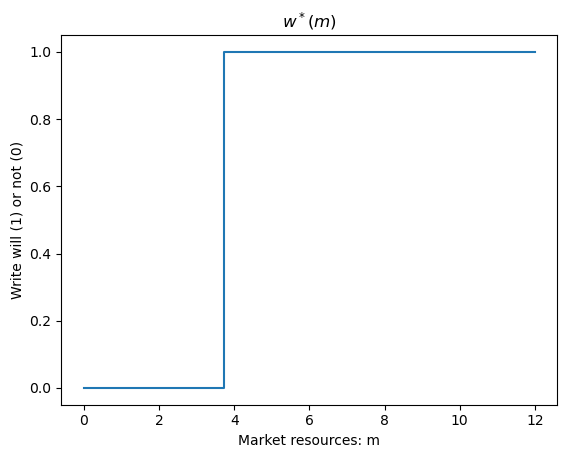

<ipython-input-2-c180c388ca61>:50: RuntimeWarning: invalid value encountered in log
  return np.log(x)


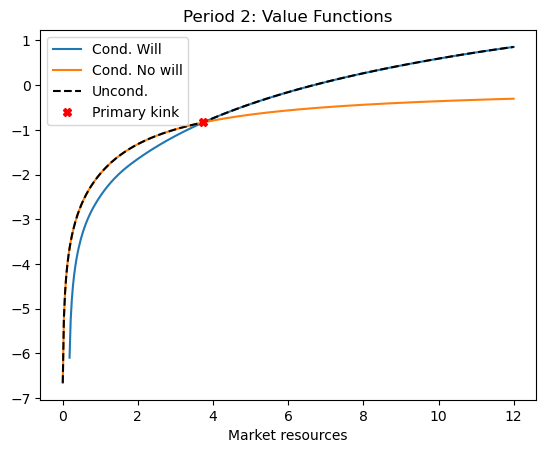

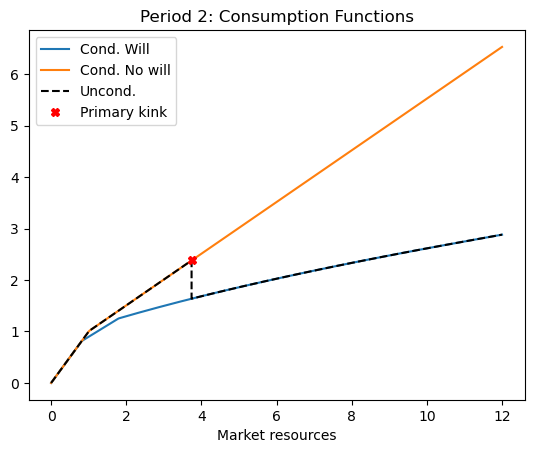

In [6]:
# We can use the upper_envelope function to find which action
# is optimal over the common grid of market resources, and
# insert the exact point in which the two actions yield equal value
# into the grid
m2_env, vt2_env, inds2_env = upper_envelope(
    [[mGrid, vT2_cond_no(mGrid)], [mGrid, vT2_cond_wi(mGrid)]]
)

# Plot the optimal decision rule
plt.plot(m2_env, inds2_env)
plt.title("$w^*(m)$")
plt.ylabel("Write will (1) or not (0)")
plt.xlabel("Market resources: m")
plt.show()

# With the decision rule, we can find unconditional consumption
c2_env = np.zeros_like(m2_env) + np.nan
c2_env[inds2_env == 0] = c2_cond_no(m2_env[inds2_env == 0])
c2_env[inds2_env == 1] = c2_cond_wi(m2_env[inds2_env == 1])

# And create the unconditional consumption and value functions
vT2 = LinearInterp(m2_env, vt2_env, lower_extrap=True)


def v2(x):
    return vUntransf(vT2(x))


c2 = LinearInterp(m2_env, c2_env, lower_extrap=True)

# The 'kink' is where the optimal action changes. Find its position to plot it
kink_idx = np.where(np.diff(inds2_env) != 0.0)

# Plot the conditional and unconditional value functions
plt.plot(m2_env, v2_cond_wi(m2_env), label="Cond. Will")
plt.plot(m2_env, v2_cond_no(m2_env), label="Cond. No will")
plt.plot(m2_env, v2(m2_env), "k--", label="Uncond.")
plt.plot(m2_env[kink_idx], v2(m2_env[kink_idx]), "rX", label="Primary kink")
plt.title("Period 2: Value Functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot the conditional and unconditional consumption
# functions
plt.plot(m2_env, c2_cond_wi(m2_env), label="Cond. Will")
plt.plot(m2_env, c2_cond_no(m2_env), label="Cond. No will")
plt.plot(m2_env, c2(m2_env), "k--", label="Uncond.")
plt.plot(m2_env[kink_idx], c2(m2_env[kink_idx]), "rX", label="Primary kink")
plt.title("Period 2: Consumption Functions")
plt.xlabel("Market resources")
plt.legend()
plt.show()

### Period 1

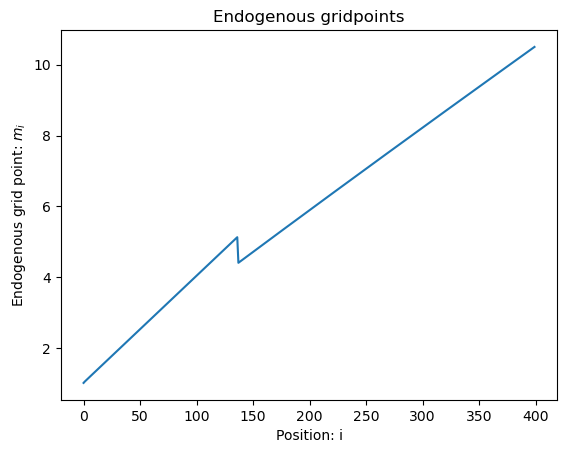

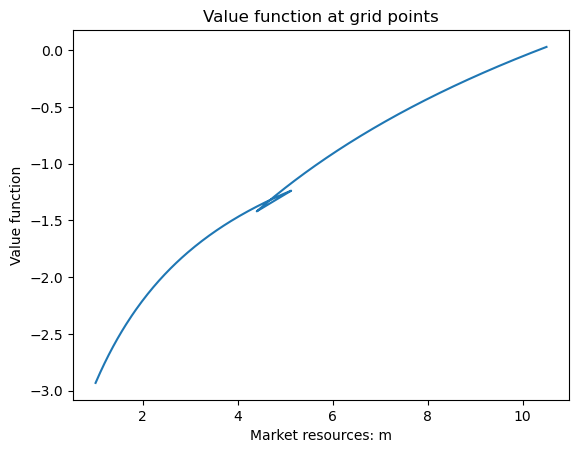

In [7]:
# EGM step

# Period 2 resources implied by the exogenous savings grid
mGrid2 = aGrid + w
# Envelope condition
vPGrid2 = uP(c2(mGrid2))
# Inversion of the euler equation
cGrid1 = uPinv(DiscFac * vPGrid2)
# Endogenous gridpoints
mGrid1 = aGrid + cGrid1
vGrid1 = u(cGrid1) + DiscFac * v2(mGrid2)

plt.plot(mGrid1)
plt.title("Endogenous gridpoints")
plt.xlabel("Position: i")
plt.ylabel("Endogenous grid point: $m_i$")
plt.show()


plt.plot(mGrid1, vGrid1)
plt.title("Value function at grid points")
plt.xlabel("Market resources: m")
plt.ylabel("Value function")
plt.show()

### DC-EGM 

In [24]:
t_start = time.time()
# Calculate envelope
# The function operates with *transformed* value grids
vTGrid1 = vTransf(vGrid1)

# Form non-decreasing segments
start, end = calc_nondecreasing_segments(mGrid1, vTGrid1)

m_segments = []
vT_segments = []
c_segments = []
for j in range(len(start)):
    idx = range(start[j], end[j] + 1)
    m_segments.append(mGrid1[idx])
    vT_segments.append(vTGrid1[idx])
    c_segments.append(cGrid1[idx])

# Get the upper envelope using m and vT
m1_env, vt1_env, idx_1 = upper_envelope(segments=list(zip(m_segments, vT_segments)))

# Store the index at which the optimal segment changes
sec_kink_idx = np.where(np.diff(idx_1) != 0.0)

# Construct enveloped consumption
c1_env = np.zeros_like(m1_env) + np.nan
for k, c_segm in enumerate(c_segments):
    c1_env[idx_1 == k] = LinearInterp(m_segments[k], c_segm)(m1_env[idx_1 == k])

# Create functions
c1_up = LinearInterp(m1_env, c1_env)
v1T_up = LinearInterp(m1_env, vt1_env)

t_end = time.time()
time_DCEGM = t_end - t_start
print("time used: ", time_DCEGM, " seconds")



time used:  0.0029993057250976562  seconds


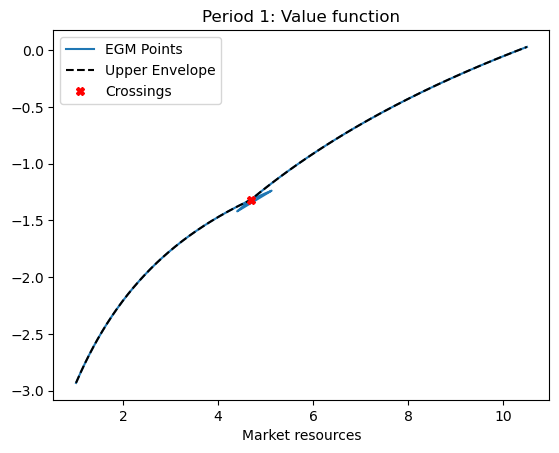

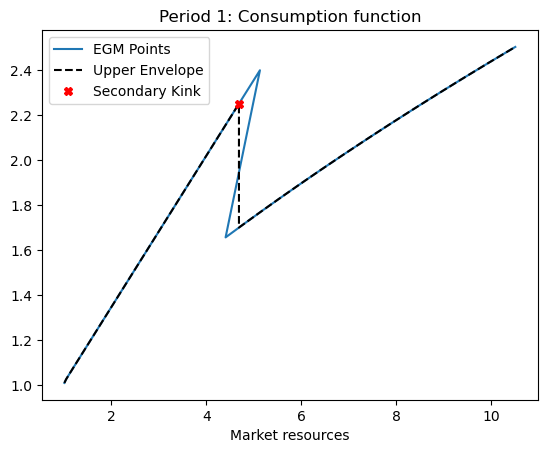

In [9]:
def v1_up(x):
    return vUntransf(v1T_up(x))

# Show that there is a non-monothonicity and that the upper envelope fixes it
plt.plot(mGrid1, vGrid1, label="EGM Points")
plt.plot(m1_env, v1_up(m1_env), "k--", label="Upper Envelope")
plt.plot(m1_env[sec_kink_idx], v1_up(m1_env[sec_kink_idx]), "rX", label="Crossings")
plt.plot()
plt.title("Period 1: Value function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot consumption
plt.plot(mGrid1, cGrid1, label="EGM Points")
plt.plot(m1_env, c1_up(m1_env), "k--", label="Upper Envelope")
plt.plot(
    m1_env[sec_kink_idx], c1_up(m1_env[sec_kink_idx]), "rX", label="Secondary Kink"
)
plt.title("Period 1: Consumption function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

### Replace it with FUES

In [19]:
# Calculate envelope
t_start = time.time()
### FUES PART STARTS HERE
m_FUES, v_FUES, c_FUES, a_FUES, dela \
    = FUES(mGrid1, vGrid1, cGrid1, aGrid) #, M_bar=2, LB=10)
### FUES PART ENDS HERE
t_end = time.time()
time_FUES = t_end - t_start
print("time used: ", time_FUES, " seconds")

time used:  0.0009906291961669922  seconds


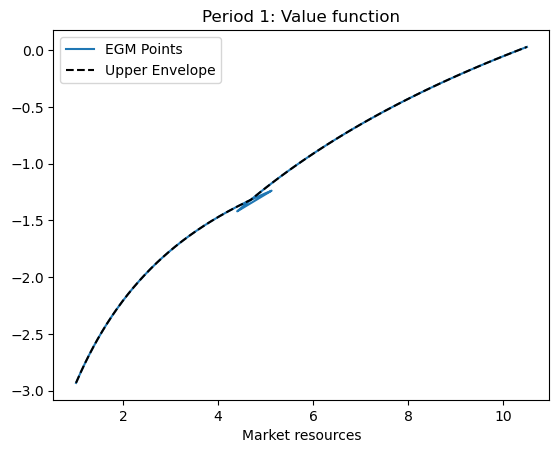

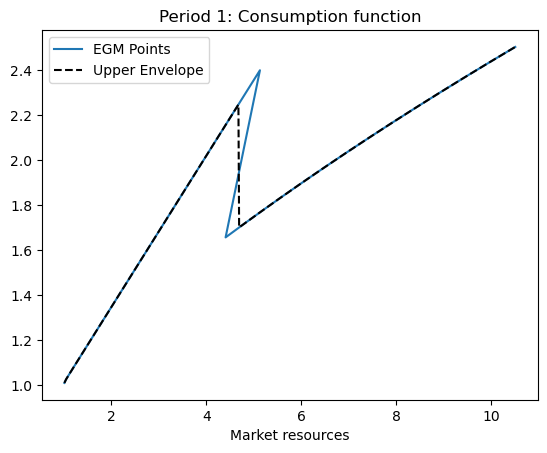

In [20]:
# Show that there is a non-monothonicity and that the upper envelope fixes it
plt.plot(mGrid1, vGrid1, label="EGM Points")
plt.plot(m_FUES, v_FUES, "k--", label="Upper Envelope")
#plt.plot(m1_env[sec_kink_idx], v1_up(m1_env[sec_kink_idx]), "rX", label="Crossings")
plt.plot()
plt.title("Period 1: Value function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot consumption
plt.plot(mGrid1, cGrid1, label="EGM Points")
plt.plot(m_FUES, c_FUES, "k--", label="Upper Envelope")
# plt.plot(
#     m1_env[sec_kink_idx], c1_up(m1_env[sec_kink_idx]), "rX", label="Secondary Kink"
# )
plt.title("Period 1: Consumption function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

### Replace with Bonner

In [21]:
t_start = time.time()
### FUES_Bonn PART STARTS HERE
m_Bonn, v_Bonn, c_Bonn \
    = fast_upper_envelope(endog_grid = mGrid1, value = vGrid1, policy = cGrid1, exog_grid = aGrid, jump_thresh=2, lower_bound_wealth = 1e-10) #, M_bar=2, LB=10)
### FUES_Bonn PART ENDS HERE
t_end = time.time()
time_Bonn = t_end - t_start
print("time used: ", time_Bonn, " seconds")

time used:  0.003998756408691406  seconds


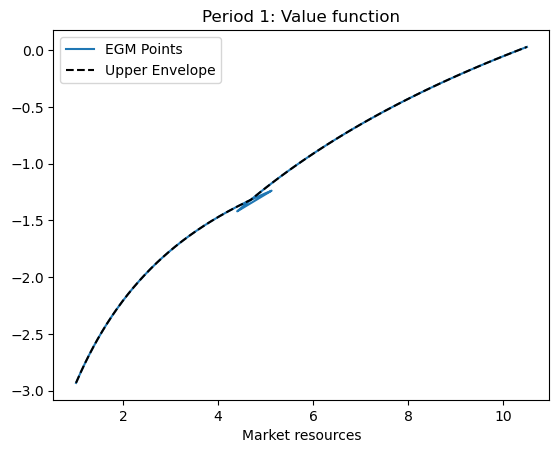

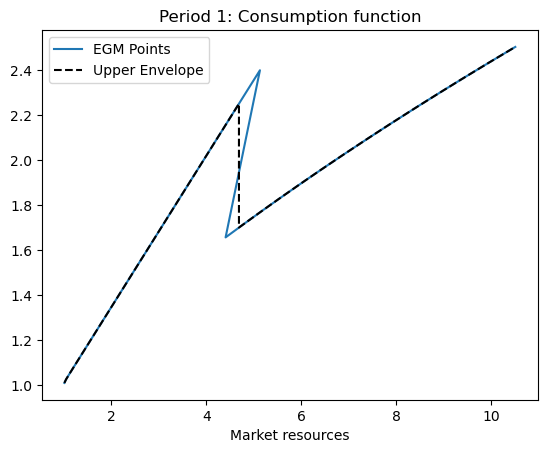

In [22]:
# Show that there is a non-monothonicity and that the upper envelope fixes it
plt.plot(mGrid1, vGrid1, label="EGM Points")
plt.plot(m_Bonn, v_Bonn, "k--", label="Upper Envelope")
plt.plot()
plt.title("Period 1: Value function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot consumption
plt.plot(mGrid1, cGrid1, label="EGM Points")
plt.plot(m_Bonn, c_Bonn, "k--", label="Upper Envelope")
plt.title("Period 1: Consumption function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

## Compare all Versions

In [23]:
# Print times
print("DC-EGM takes: ", time_DCEGM, " seconds")
print("FUES (Original) takes: ", time_FUES, " seconds")
print("FUES (Bonn) takes: ", time_Bonn, " seconds")


DC-EGM takes:  0.0029990673065185547  seconds
FUES (Original) takes:  0.0009906291961669922  seconds
FUES (Bonn) takes:  0.003998756408691406  seconds


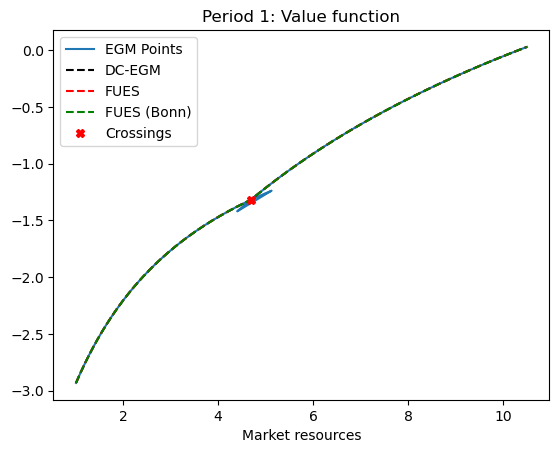

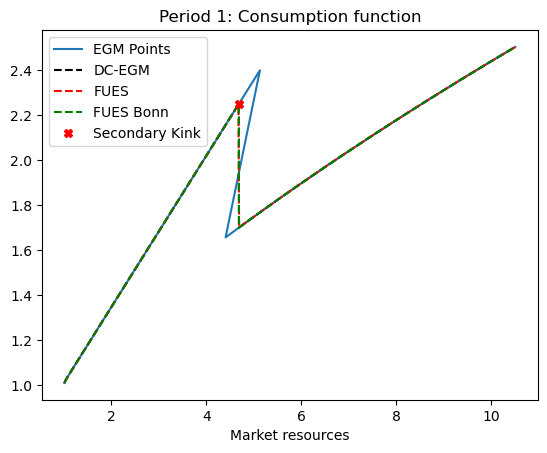

In [15]:
# Show that there is a non-monothonicity and that the upper envelope fixes it
plt.plot(mGrid1, vGrid1, label="EGM Points")
plt.plot(m1_env, v1_up(m1_env), "k--", label="DC-EGM")
plt.plot(m_FUES, v_FUES, "r--", label="FUES")
plt.plot(m_Bonn, v_Bonn, "g--", label="FUES (Bonn)")
plt.plot(m1_env[sec_kink_idx], v1_up(m1_env[sec_kink_idx]), "rX", label="Crossings")
plt.plot()
plt.title("Period 1: Value function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Plot consumption
plt.plot(mGrid1, cGrid1, label="EGM Points")
plt.plot(m1_env, c1_up(m1_env), "k--", label="DC-EGM")
plt.plot(m_FUES, c_FUES, "r--", label="FUES")
plt.plot(m_Bonn, c_Bonn, "g--", label="FUES Bonn")
plt.plot(
    m1_env[sec_kink_idx], c1_up(m1_env[sec_kink_idx]), "rX", label="Secondary Kink"
)
plt.title("Period 1: Consumption function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

# Linear Interpolation and evaluation on same grid!

In [16]:
c_Func_DCEGM = LinearInterp(m1_env, c1_up(m1_env))
c_Func_FUES = LinearInterp(m_FUES, c_FUES)
c_Func_Bonn = LinearInterp(m_Bonn, c_Bonn)


In [17]:
c_array_DCEGM = c_Func_DCEGM(m_Bonn)
c_array_FUES = c_Func_FUES(m_Bonn)
c_array_Bonn = c_Func_Bonn(m_Bonn)


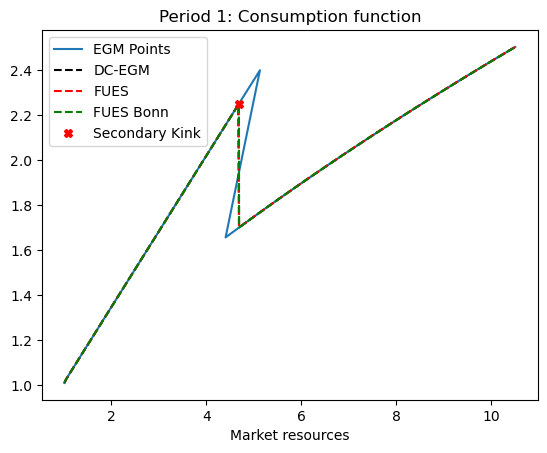

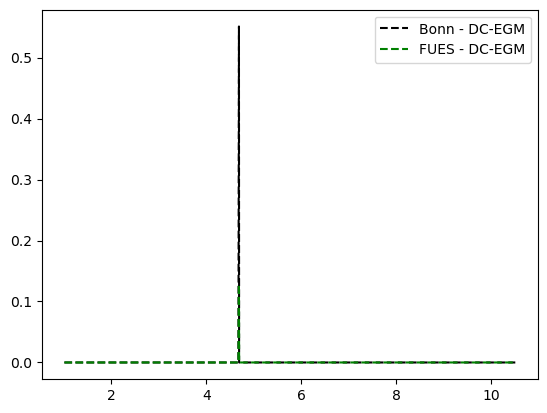

In [18]:
plt.plot(mGrid1, cGrid1, label="EGM Points")
plt.plot(m_Bonn, c_array_DCEGM, "k--", label="DC-EGM")
plt.plot(m_Bonn, c_array_FUES, "r--", label="FUES")
plt.plot(m_Bonn, c_array_Bonn, "g--", label="FUES Bonn")
plt.plot(
    m1_env[sec_kink_idx], c1_up(m1_env[sec_kink_idx]), "rX", label="Secondary Kink"
)
plt.title("Period 1: Consumption function")
plt.xlabel("Market resources")
plt.legend()
plt.show()

plt.plot(m_Bonn, c_array_Bonn - c_array_DCEGM, "k--", label="Bonn - DC-EGM")
plt.plot(m_Bonn, c_array_FUES - c_array_DCEGM, "g--", label="FUES - DC-EGM")
plt.legend()
plt.show()